In [1]:
from PIL import Image
import sys
import os
import urllib
import tensorflow.contrib.tensorrt as trt
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import numpy as np
import time
from tf_trt_models.detection import download_detection_model, build_detection_graph

%matplotlib inline

In [2]:
MODEL = 'ssdlite_mobilenet_v2_coco'
DATA_DIR = './data/'
CONFIG_FILE = MODEL + '.config'   # ./data/ssd_inception_v2_coco.config 
CHECKPOINT_FILE = 'model.ckpt'    # ./data/ssd_inception_v2_coco/model.ckpt
IMAGE_PATH = './data/huskies.jpg'

### Download the pretrained model

Download the model configuration file and checkpoint containing pretrained weights by using the following command.  

For improved performance, increase the non-max suppression score threshold in the downloaded config file from 1e-8 to something greater, like 0.1.

In [3]:
config_path, checkpoint_path = download_detection_model(MODEL, 'data')

### Build the frozen graph

In [4]:
frozen_graph, input_names, output_names = build_detection_graph(
    config=config_path,
    checkpoint=checkpoint_path,
    score_threshold=0.3,
    batch_size=1
)

INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
INFO:tensorflow:Restoring parameters from data/ssdlite_mobilenet_v2_coco_2018_05_09/model.ckpt
INFO:tensorflow:Restoring parameters from data/ssdlite_mobilenet_v2_coco_2018_05_09/model.ckpt
INFO:tensorflow:Froze 404 variables.
INFO:tensorflow:Converted 404 variables to const ops.
INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: .generated_model/saved_model/saved_model.pb


INFO:tensorflow:SavedModel written to: .generated_model/saved_model/saved_model.pb


INFO:tensorflow:Writing pipeline config file to .generated_model/pipeline.config


INFO:tensorflow:Writing pipeline config file to .generated_model/pipeline.config


### Optimize the model with TensorRT

In [5]:
print(output_names)

['detection_boxes', 'detection_classes', 'detection_scores', 'num_detections']


In [6]:
trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,
    outputs=output_names,
    max_batch_size=1,
    max_workspace_size_bytes=1 << 25,
    precision_mode='FP16',
    minimum_segment_size=50
)

In [7]:
with open('./data/ssd_inception_v2_coco_trt.pb', 'wb') as f:
    f.write(trt_graph.SerializeToString())

### Create session and load graph

In [12]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

tf_sess = tf.Session(config=tf_config)

tf.import_graph_def(trt_graph, name='')

tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_scores = tf_sess.graph.get_tensor_by_name('detection_scores:0')
tf_boxes = tf_sess.graph.get_tensor_by_name('detection_boxes:0')
tf_classes = tf_sess.graph.get_tensor_by_name('detection_classes:0')
tf_num_detections = tf_sess.graph.get_tensor_by_name('num_detections:0')

### Load and Preprocess Image

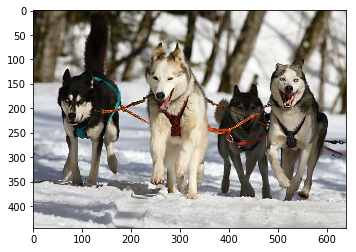

In [9]:
image = Image.open(IMAGE_PATH)

plt.imshow(image)

image_resized = np.array(image.resize((300, 300)))
image = np.array(image)

### Run network on Image

In [13]:
scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
    tf_input: image_resized[None, ...]
})

boxes = boxes[0] # index by 0 to remove batch dimension
scores = scores[0]
classes = classes[0]
num_detections = num_detections[0]

ResourceExhaustedError: OOM when allocating tensor with shape[1,32,150,150] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: FeatureExtractor/MobilenetV2/Conv/Conv2D = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 2, 2], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](FeatureExtractor/MobilenetV2/Conv/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer, FeatureExtractor/MobilenetV2/Conv/weights)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: Postprocessor/ExpandDims_1/_5 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2267_Postprocessor/ExpandDims_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'FeatureExtractor/MobilenetV2/Conv/Conv2D', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/nvidia/.local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/nvidia/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/nvidia/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/nvidia/.local/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/home/nvidia/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/nvidia/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/nvidia/.local/lib/python3.5/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/nvidia/.local/lib/python3.5/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/nvidia/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "/home/nvidia/.local/lib/python3.5/site-packages/tornado/gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/nvidia/.local/lib/python3.5/site-packages/tornado/gen.py", line 1080, in __init__
    self.run()
  File "/home/nvidia/.local/lib/python3.5/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/nvidia/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/nvidia/.local/lib/python3.5/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/nvidia/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/nvidia/.local/lib/python3.5/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/nvidia/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/nvidia/.local/lib/python3.5/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/nvidia/.local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/nvidia/.local/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/nvidia/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/nvidia/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/nvidia/.local/lib/python3.5/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/nvidia/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/nvidia/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/nvidia/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-a88657704362>", line 6, in <module>
    tf.import_graph_def(trt_graph, name='')
  File "/home/nvidia/.local/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py", line 432, in new_func
    return func(*args, **kwargs)
  File "/home/nvidia/.local/lib/python3.5/site-packages/tensorflow/python/framework/importer.py", line 442, in import_graph_def
    _ProcessNewOps(graph)
  File "/home/nvidia/.local/lib/python3.5/site-packages/tensorflow/python/framework/importer.py", line 234, in _ProcessNewOps
    for new_op in graph._add_new_tf_operations(compute_devices=False):  # pylint: disable=protected-access
  File "/home/nvidia/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3563, in _add_new_tf_operations
    for c_op in c_api_util.new_tf_operations(self)
  File "/home/nvidia/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3563, in <listcomp>
    for c_op in c_api_util.new_tf_operations(self)
  File "/home/nvidia/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3450, in _create_op_from_tf_operation
    ret = Operation(c_op, self)
  File "/home/nvidia/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1,32,150,150] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: FeatureExtractor/MobilenetV2/Conv/Conv2D = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 2, 2], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](FeatureExtractor/MobilenetV2/Conv/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer, FeatureExtractor/MobilenetV2/Conv/weights)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: Postprocessor/ExpandDims_1/_5 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2267_Postprocessor/ExpandDims_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



### Display Results

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.imshow(image)

# plot boxes exceeding score threshold
for i in range(num_detections):
    # scale box to image coordinates
    box = boxes[i] * np.array([image.shape[0], image.shape[1], image.shape[0], image.shape[1]])

    # display rectangle
    patch = patches.Rectangle((box[1], box[0]), box[3] - box[1], box[2] - box[0], color='g', alpha=0.3)
    ax.add_patch(patch)

    # display class index and score
    plt.text(x=box[1] + 10, y=box[2] - 10, s='%d (%0.2f) ' % (classes[i], scores[i]), color='w')

plt.show()

### Benchmark

In [ ]:
num_samples = 50

t0 = time.time()
for i in range(num_samples):
    scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
        tf_input: image_resized[None, ...]
    })
t1 = time.time()
print('Average runtime: %f seconds' % (float(t1 - t0) / num_samples))

### Close session to release resources

In [ ]:
tf_sess.close()